### Modeling with Binned Features
This notebook takes a look at how our model performs when the categorical variables (carriers, branded code share, and airport IDs) are binned.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import (log_loss,
                            roc_auc_score, 
                            recall_score, 
                            precision_score, 
                            average_precision_score, 
                            f1_score, classification_report, 
                            accuracy_score, plot_roc_curve, 
                            plot_precision_recall_curve, 
                            plot_confusion_matrix
                        )

In [2]:
binned_flights = pd.read_csv("Features_with_binning.csv")

In [3]:
binned_flights.drop(["Unnamed: 0", "fl_date"], axis=1, inplace=True)

In [4]:
# check
binned_flights.head()

,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,...,origin_airport_id_9000 to 12000 departures,origin_airport_id_More than 12000 departures,dest_airport_id_0 to 4000 arrivals,dest_airport_id_4000 to 9000 arrivals,dest_airport_id_9000 to 12000 arrivals,dest_airport_id_More than 12000 arrivals,Weather_Cloudy,Weather_Rainy,Weather_Snowy,Weather_Sunny
0,1229,1337.0,68.0,12.0,1349.0,1452.0,9.0,1355,1501.0,66.0,...,0,0,0,0,0,1,0,1,0,0
1,1945,1941.0,-4.0,15.0,1956.0,2209.0,6.0,2244,2215.0,-29.0,...,1,0,0,0,1,0,1,0,0,0
2,1110,1107.0,-3.0,32.0,1139.0,1844.0,12.0,1855,1856.0,1.0,...,1,0,0,0,1,0,0,0,0,1
3,1739,1736.0,-3.0,11.0,1747.0,1911.0,4.0,1930,1915.0,-15.0,...,0,1,0,1,0,0,0,1,0,0
4,930,926.0,-4.0,12.0,938.0,1607.0,7.0,1649,1614.0,-35.0,...,0,1,0,0,0,1,0,1,0,0


In [5]:
# binned_flights.columns.tolist()

In [6]:
# dropping weather because it was turned into dummy variables
binned_flights.drop("Weather", axis=1, inplace=True)

In [7]:
numeric = ['crs_dep_time',
         'dep_time',
         'dep_delay',
         'taxi_out',
         'wheels_off',
         'wheels_on',
         'taxi_in',
         'crs_arr_time',
         'arr_time',
         'arr_delay',
         'crs_elapsed_time',
         'actual_elapsed_time',
         'air_time',
         'distance']

categoric = list(set(binned_flights.columns) - set(numeric) - {'arr_delay'})

First, let's look at the correlation between the different variables, then at the most correlated features with arr_delay where the correlation is more than 0.5.

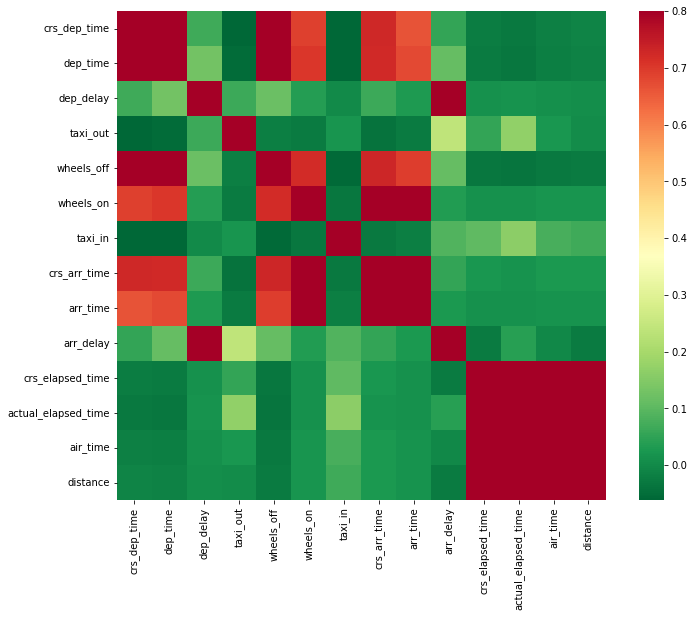

In [8]:
corrmat = binned_flights[numeric].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="RdYlGn_r")

plt.show()

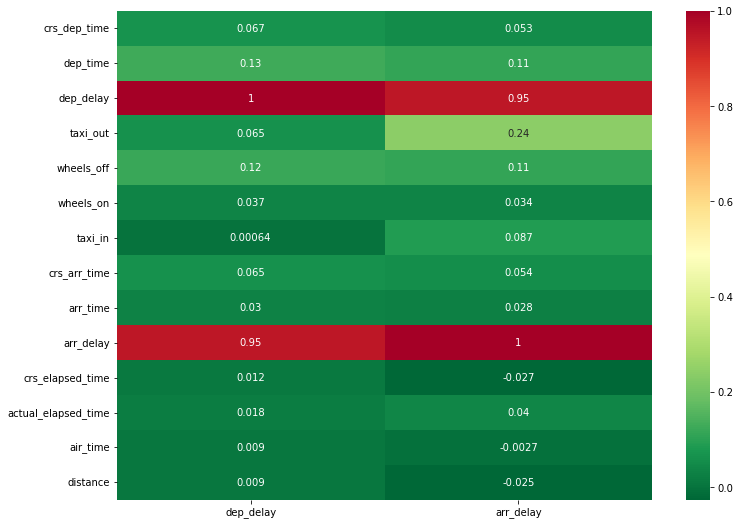

In [9]:
corrmat = binned_flights[numeric].corr()

high_corr = corrmat.index[abs(corrmat['arr_delay'])>0.5]
plt.figure(figsize=(12,9))
sns.heatmap(corrmat[high_corr], annot=True, cmap='RdYlGn_r')

plt.show()

Departure delay is a strong predictor of arrival delay due to the high correlation. We will remove departure delay.

In [10]:
# drop dep_delay
binned_flights.drop("dep_delay", axis=1, inplace=True)

In [11]:
# updating numeric list to exclude arr_delay and dep_delay
numeric = [item for item in numeric if item not in ('arr_delay', 'dep_delay')]

numeric

['crs_dep_time',
 'dep_time',
 'taxi_out',
 'wheels_off',
 'wheels_on',
 'taxi_in',
 'crs_arr_time',
 'arr_time',
 'crs_elapsed_time',
 'actual_elapsed_time',
 'air_time',
 'distance']

# Modeling

In [12]:
# separate target and predictors
y = binned_flights['arr_delay']
X = binned_flights.drop('arr_delay', axis=1)

In [13]:
seed = 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [30]:
def scale_features(X_train, X_test, numeric_cols, cat_cols, scaler):
    '''returns X_train and X_test array where the numerical columns are scaled, 
    then combines it with the categorical array'''
    scaler = scaler.fit(X_train[numeric_cols])
    
    X_train_scaled = scaler.transform(X_train[numeric_cols])
    X_test_scaled = scaler.transform(X_test[numeric_cols])
    
    # combine with categorical columns
    X_train_scaled_comb = np.hstack((X_train_scaled, X_train[cat_cols]))
    X_test_scaled_comb = np.hstack((X_test_scaled, X_test[cat_cols]))
    
    return X_train_scaled_comb, X_test_scaled_comb

In [36]:
scaler = StandardScaler()

X_train_scaled, X_test_scaled = scale_features(X_train, X_test, numeric, categoric, scaler)

#### Linear Regression

In [44]:
def regression_metrics(y_true, yhat):
    '''return R^2, MSE, MAE, and RMSE metrics'''
    
    print(f'R^2: {metrics.r2_score(y_true, yhat)}')
    print(f'Mean Squared Error: {metrics.mean_squared_error(y_true, yhat)}')
    print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_true, yhat)}')
    print(f'Root MSE: {metrics.mean_squared_error(y_true, yhat, squared=False)}')

In [37]:
line_reg = LinearRegression()

line_reg.fit(X_train_scaled, y_train)

yhat_line = line_reg.predict(X_test_scaled)

In [50]:
regression_metrics(y_test, yhat_line)

R^2: 0.1961162948920736
Mean Squared Error: 1612.979671174722
Mean Absolute Error: 17.720410060397278
Root MSE: 40.16191817100774


#### Random Forest

In [42]:
rfc = RandomForestRegressor(n_estimators=10, max_depth=8, random_state=seed)

rfc.fit(X_train_scaled, y_train)

yhat_rfc = rfc.predict(X_test_scaled)

In [51]:
regression_metrics(y_test, yhat_rfc)

R^2: 0.6262132494705532
Mean Squared Error: 749.9970780941634
Mean Absolute Error: 16.373658992033675
Root MSE: 27.386074528748427


#### Naive Bayes

In [54]:
gauss = GaussianNB()

gauss.fit(X_train_scaled, y_train) 

yhat_nb = gauss.predict(X_test_scaled)

In [69]:
regression_metrics(y_test, yhat_nb)

R^2: -72.21370952636099
Mean Squared Error: 146902.12572657724
Mean Absolute Error: 357.8288862745644
Root MSE: 383.2781310309489
